# Customer Churn(attrition) Prediction 

TASK : Develop a model to predict customer churn for a subscription-based service or business.

we want to predict customers are leaving the subscription or business || Here the [Exited] column typically represents whether a customer has left (churned) or stayed with the subscription-based service. Specifically:
If the value of Exited is 1, it means the customer has exited, i.e., they have churned or discontinued their subscription.
If the value of Exited is 0, it means the customer has not exited, i.e., they are still an active subscriber.

In [129]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [71]:
data = pd.read_csv(r'E:\DATA-SCIENCE\Project\CODSOFT\archive (2)\Churn_Modelling.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
#Let check the data shape : 10000 raws with 14 features 
data.shape

(10000, 14)

In [5]:
#Member actived score : 5151 activated and 4849 not members  
data['IsActiveMember'].value_counts()

IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

In [6]:
#There are 7963 customers don't want to churn as they not exited for churning the business or subscription
#Remaining 2037 left the subscription as they exited 
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

**Exploratory Data Analysis (EDA)**

In [7]:
#count the numbers of active and Deactive members with geography 
active_member = data[data['IsActiveMember'] == 1]
geography_active = active_member.groupby('Geography').agg({'IsActiveMember':'count'}).reset_index()
deactive_member = data[data['IsActiveMember'] == 0]
geography_deactive = deactive_member.groupby('Geography').agg({'IsActiveMember':'count'}).reset_index()
geography_active.rename(columns={'IsActiveMember':'Active_count'},inplace=True)
geography_deactive.rename(columns={'IsActiveMember':'Deactive_count'},inplace=True)
print("Active Members based on Geography")
print("*"*50)
print(geography_active)
print("Deactive Members based on Geography")
print("*"*50)
print(geography_deactive)

Active Members based on Geography
**************************************************
  Geography  Active_count
0    France          2591
1   Germany          1248
2     Spain          1312
Deactive Members based on Geography
**************************************************
  Geography  Deactive_count
0    France            2423
1   Germany            1261
2     Spain            1165


In [8]:
#each values count of Geography 
data['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [9]:
#count the numbers of active and Deactive members with Tenure(A period of time in years) 
active_member = data[data['IsActiveMember'] == 1]
tenure_active = active_member.groupby('Tenure').agg({'IsActiveMember':'count'}).reset_index()
deactive_member = data[data['IsActiveMember'] == 0]
tenure_deactive = deactive_member.groupby('Tenure').agg({'IsActiveMember':'count'}).reset_index()
tenure_active.rename(columns={'IsActiveMember':'Active_count'},inplace=True)
tenure_deactive.rename(columns={'IsActiveMember':'Deactive_count'},inplace=True)
print("Active Members based on Tenure")
print("*"*50)
print(tenure_active.sort_values(by='Active_count',ascending=False))
print("Deactive Members based on Tenure")
print("*"*50)
print(tenure_deactive.sort_values(by='Deactive_count',ascending=False))
#result 
#with 1 to 3 years of time period customes are still active and longer or older customers are deactivated members 

Active Members based on Tenure
**************************************************
    Tenure  Active_count
1        1           569
2        2           560
7        7           535
3        3           524
8        8           519
5        5           506
4        4           500
6        6           499
9        9           471
10      10           249
0        0           219
Deactive Members based on Tenure
**************************************************
    Tenure  Deactive_count
9        9             513
5        5             506
8        8             506
7        7             493
4        4             489
2        2             488
3        3             485
6        6             468
1        1             466
10      10             241
0        0             194


In [10]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [11]:
#Missing values 
print(data.isnull().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [12]:
print(data.describe())

         RowNumber    CustomerId   CreditScore           Age        Tenure   
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000  \
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember   
count   10000.000000   10000.000000  10000.00000    10000.000000  \
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000     

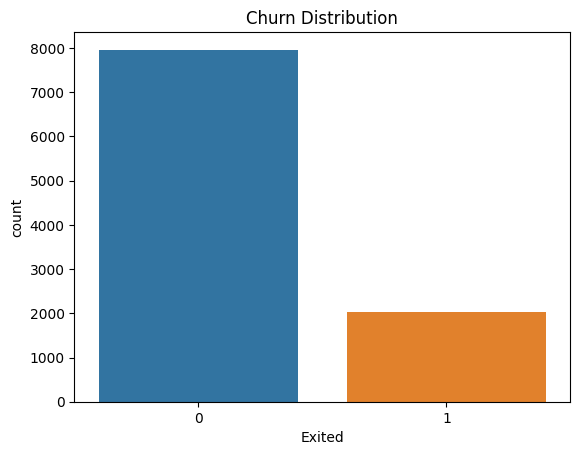

In [13]:
#Churn Distribution 
ax = sns.countplot(x='Exited',data=data)
plt.title('Churn Distribution')
plt.show()

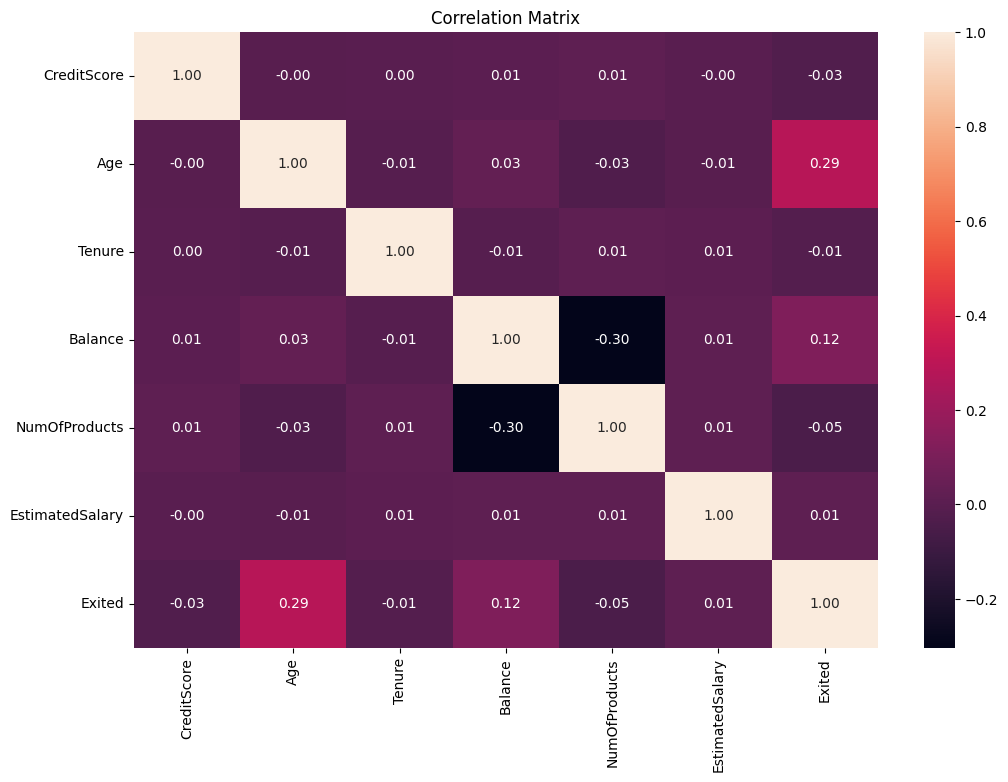

In [14]:
#Correlation Matrix 
numeric_features = data.loc[:,['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','Exited']]
plt.figure(figsize=(12,8))
sns.heatmap(numeric_features.corr(),annot=True,fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

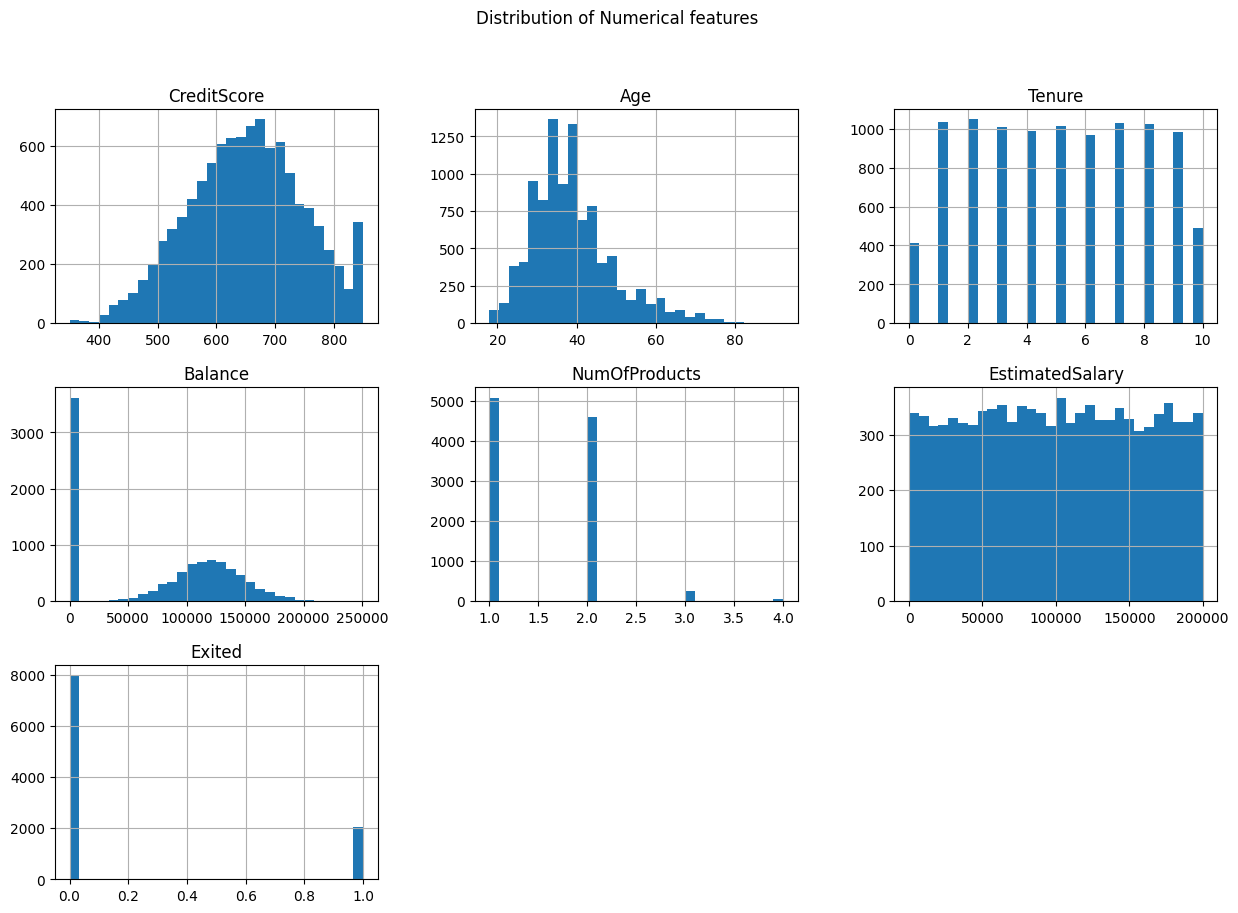

In [15]:
#Distribution of Numerical features 
numeric_features_text = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','Exited']
data[numeric_features_text].hist(bins=30,figsize=(15,10))
plt.suptitle('Distribution of Numerical features')
plt.show()

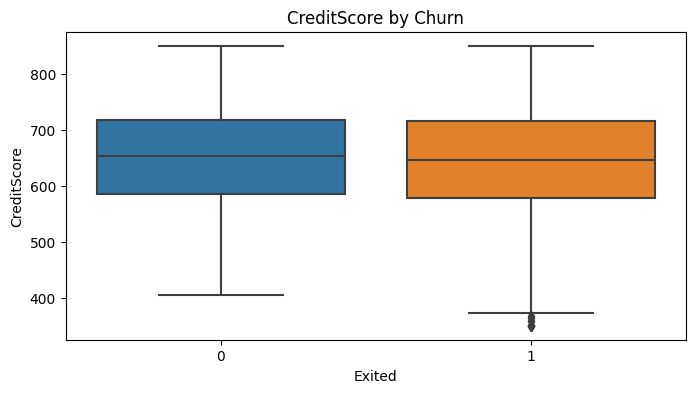

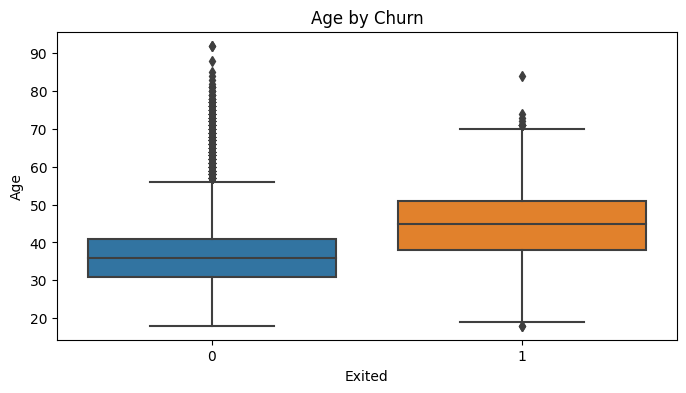

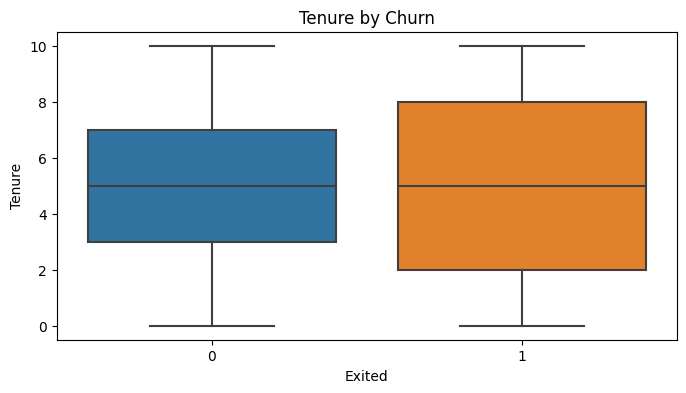

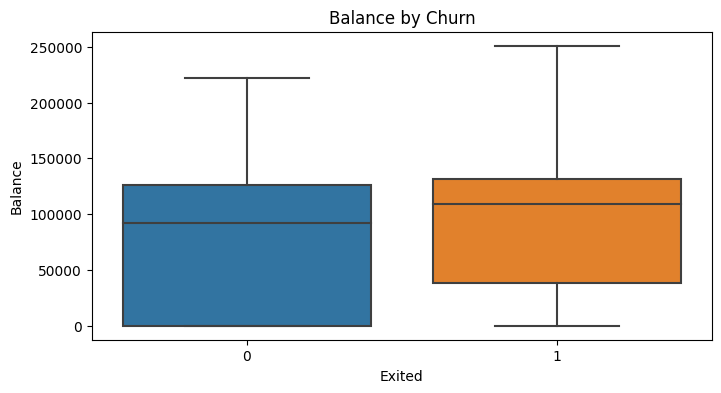

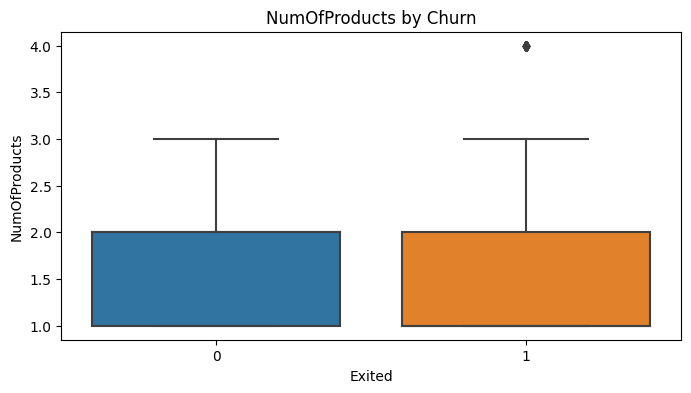

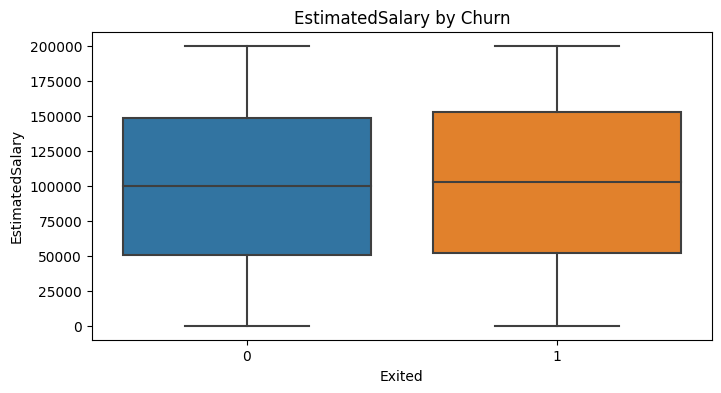

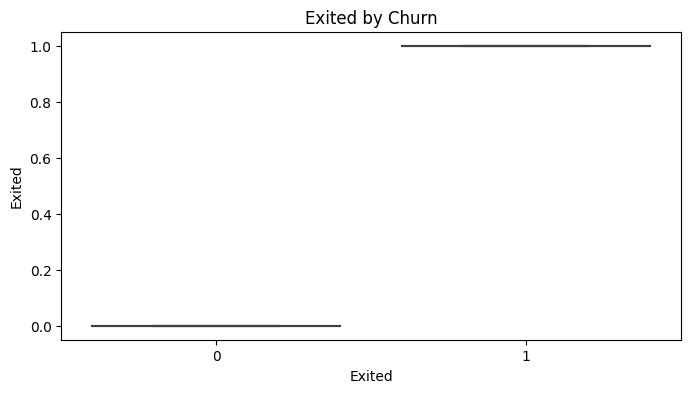

In [16]:
# Box plots of numerical features by churn
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Exited', y=feature, data=data)
    plt.title(f'{feature} by Churn')
    plt.show()

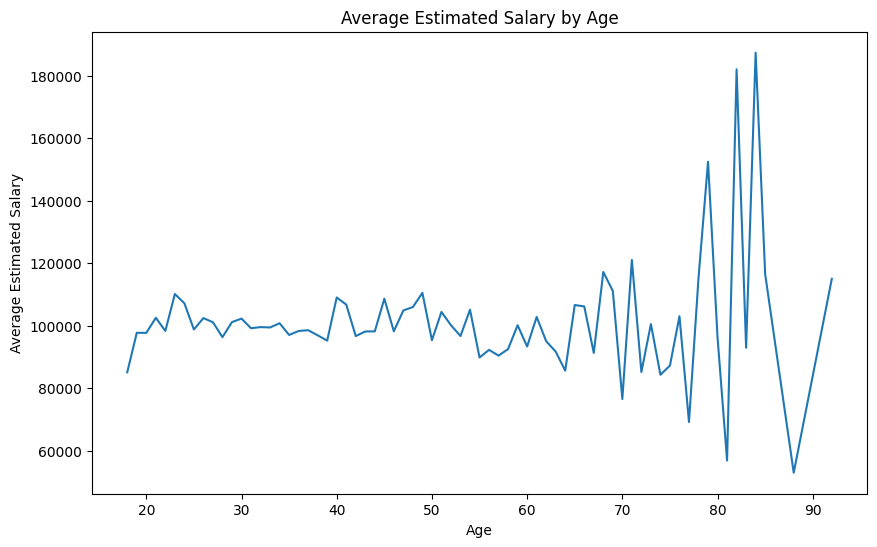

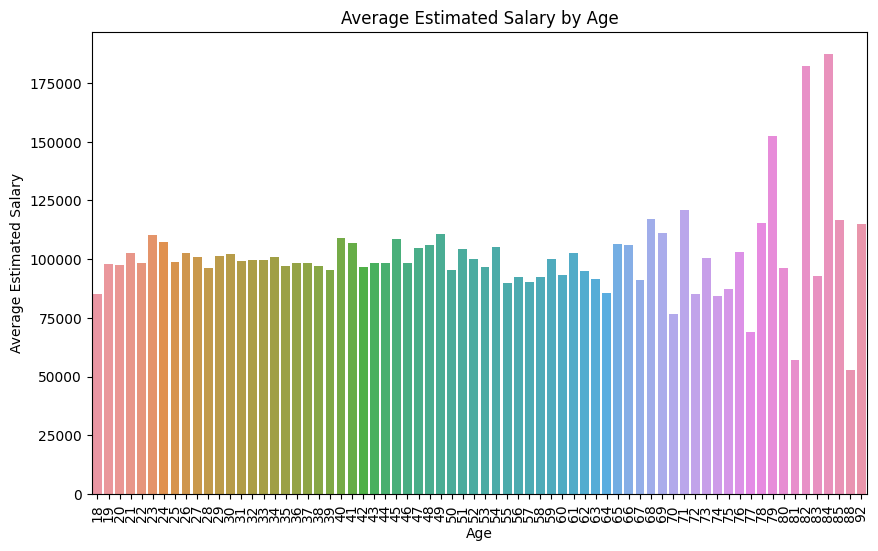

In [17]:
#Average salary by age 
avg_salary_by_age = data.groupby('Age')['EstimatedSalary'].mean().reset_index()
# Line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Age', y='EstimatedSalary', data=avg_salary_by_age)
plt.title('Average Estimated Salary by Age')
plt.xlabel('Age')
plt.ylabel('Average Estimated Salary')
plt.show()
#hist plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Age', y='EstimatedSalary', data=avg_salary_by_age)
plt.title('Average Estimated Salary by Age')
plt.xlabel('Age')
plt.xticks(rotation=90)
plt.ylabel('Average Estimated Salary')
plt.show()

In [75]:
#Creating age group with category 
data['AgeGroup'] = pd.cut(data['Age'],bins=[18,30,40,50,60,100],labels=['18-30','31-40','41-50','51-60','60+'])

In [77]:
#insert the age_group at 6th index
data.insert(6,'AgeGroup',data.pop('AgeGroup'))

In [78]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,AgeGroup,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,41-50,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41-50,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,41-50,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,31-40,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,41-50,43,2,125510.82,1,1,1,79084.10,0


**Encoding**

In [79]:
data['Gender'] = data['Gender'].map({'Female':0,'Male':1})

In [80]:
data['Geography'] = data['Geography'].map({'France':0,'Germany':1,'Spain':2})

In [54]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,AgeGroup,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,0,0,41-50,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,2,0,41-50,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,0,0,41-50,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,0,0,31-40,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,2,0,41-50,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,2,1,41-50,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,0,1,41-50,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,1,0,18-30,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,0,1,41-50,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,0,1,18-30,27,2,134603.88,1,1,1,71725.73,0


In [81]:
#onehot encoding for age group 
data['AgeGroup'] = data['AgeGroup'].cat.add_categories('Unknown').fillna('Unknown') #as we have missing values 
encode = OneHotEncoder(sparse_output=False,drop='first')
age_group_encoding = encode.fit_transform(data[['AgeGroup']])
encoded_column_name = encode.get_feature_names_out(['AgeGroup'])

In [64]:
encoded_column_name

array(['AgeGroup_31-40', 'AgeGroup_41-50', 'AgeGroup_51-60',
       'AgeGroup_60+', 'AgeGroup_Unknown'], dtype=object)

In [82]:
#create the encoded dataframe 
age_group_df = pd.DataFrame(age_group_encoding,columns=encoded_column_name)
#as we working with 0 and 1 classification so converted the float to int 
age_group_df = age_group_df.astype('int')

In [83]:
#inset the age_group dataframe columns at index 6
for i,col in enumerate(age_group_df.columns):
    #from the 6th index the encoded columns will insert 
    data.insert(6+i,col,age_group_df[col])   

In [84]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,AgeGroup_31-40,AgeGroup_41-50,AgeGroup_51-60,AgeGroup_60+,AgeGroup_Unknown,AgeGroup,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,0,0,0,1,0,0,0,41-50,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,2,0,0,1,0,0,0,41-50,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,0,0,0,1,0,0,0,41-50,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,0,0,1,0,0,0,0,31-40,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,2,0,0,1,0,0,0,41-50,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,0,1,1,0,0,0,0,31-40,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,0,1,1,0,0,0,0,31-40,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,0,0,1,0,0,0,0,31-40,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,1,1,0,1,0,0,0,41-50,42,3,75075.31,2,1,0,92888.52,1


**Model Development**

In [87]:
#Selection of Data
X_column = ['CreditScore', 'Geography',
       'Gender', 'AgeGroup_31-40', 'AgeGroup_41-50', 'AgeGroup_51-60',
       'AgeGroup_60+','Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary']
X = data.loc[:,X_column]

In [88]:
X

,CreditScore,Geography,Gender,AgeGroup_31-40,AgeGroup_41-50,AgeGroup_51-60,AgeGroup_60+,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,0,1,0,0,2,0.00,1,1,1,101348.88
1,608,2,0,0,1,0,0,1,83807.86,1,0,1,112542.58
2,502,0,0,0,1,0,0,8,159660.80,3,1,0,113931.57
3,699,0,0,1,0,0,0,1,0.00,2,0,0,93826.63
4,850,2,0,0,1,0,0,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,1,0,0,0,5,0.00,2,1,0,96270.64
9996,516,0,1,1,0,0,0,10,57369.61,1,1,1,101699.77
9997,709,0,0,1,0,0,0,7,0.00,1,0,1,42085.58
9998,772,1,1,0,1,0,0,3,75075.31,2,1,0,92888.52


In [95]:
y = data['Exited']

In [96]:
y

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

In [97]:
#split the data for train and test process 
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [98]:
X_train.shape,y_train.shape

((8000, 13), (8000,))

In [100]:
#Logistic Model 
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [105]:
#Prediction on test data
pred_test = log_model.predict(X_test)
accuracy_log = accuracy_score(y_test,pred_test)*100
print("Accuracy Score on test data :{:.2f}%".format(accuracy_log))

Accuracy Score on test data :80.35%


In [106]:
#Confusion matrix
cm_log = confusion_matrix(y_test,pred_test)
print(cm_log)

[[1607    0]
 [ 393    0]]


In [109]:
collections.Counter(pred_test)  #out model predict all test data as 0 

Counter({0: 2000})

In [111]:
#Now try with Feature Scaling 
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [113]:
#again train the model with scaling data
log_model_scale = log_model.fit(X_train_scaler,y_train)

In [114]:
pred_test_scale = log_model_scale.predict(X_test_scaler)

In [117]:
#Accuracy 
accuracy_on_scale = accuracy_score(y_test,pred_test_scale)*100
print("Accuracy on test data: {:.2f}%".format(accuracy_on_scale))

Accuracy on test data: 82.55%


In [115]:
#confusion matrix
cm_scale = confusion_matrix(y_test,pred_test_scale)
print(cm_scale)

[[1541   66]
 [ 283  110]]


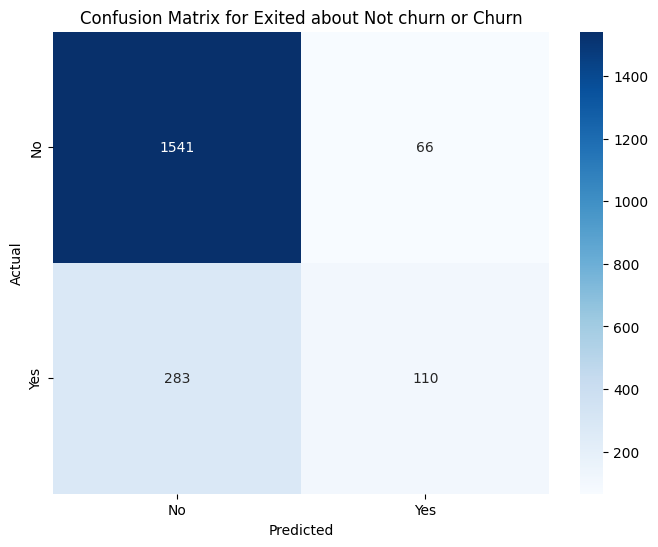

In [119]:
#plot the confusion matrix
labels = ['No','Yes']
plt.figure(figsize=(8,6))
sns.heatmap(cm_scale,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Exited about Not churn or Churn')
plt.show()

In [118]:
#classification report
cf_scale = classification_report(y_test,pred_test_scale)
print(cf_scale)

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1607
           1       0.62      0.28      0.39       393

    accuracy                           0.83      2000
   macro avg       0.73      0.62      0.64      2000
weighted avg       0.80      0.83      0.80      2000



**Random Forest Model**

In [121]:
random_model = RandomForestClassifier(n_estimators=100,random_state=42)

In [123]:
random_model.fit(X_train_scaler,y_train)

RandomForestClassifier(random_state=42)

In [124]:
pred_test_random = random_model.predict(X_test_scaler)

In [126]:
#Accuracy 
accuracy_on_randomforest = accuracy_score(y_test,pred_test_random)*100
print("Accuracy Score:{:.2f}%".format(accuracy_on_randomforest))

Accuracy Score:85.85%


In [127]:
cm_random = confusion_matrix(y_test,pred_test_random)
print(cm_random)

[[1539   68]
 [ 215  178]]


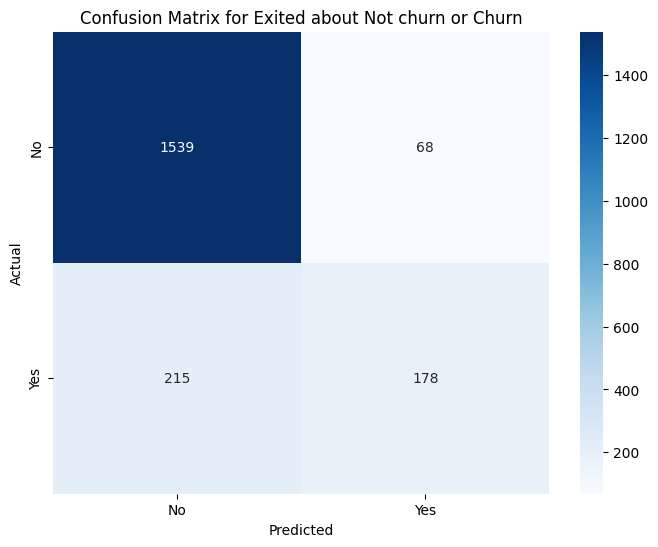

In [128]:
#plot the confusion matrix
labels = ['No','Yes']
plt.figure(figsize=(8,6))
sns.heatmap(cm_random,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Exited about Not churn or Churn')
plt.show()

In [131]:
#Let use cross-validation with grid search to improve the random forest model 
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}
random_model_for_grid = RandomForestClassifier(n_estimators=100,random_state=42)
grid_search = GridSearchCV(estimator=random_model_for_grid,param_grid=param_grid,cv=5,scoring='accuracy')

In [132]:
grid_search.fit(X_train_scaler,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [133]:
best_param = grid_search.best_params_
print("Best Parameters:",best_param)

Best Parameters: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [134]:
random_model_2 = RandomForestClassifier(n_estimators=100,random_state=42,**best_param)

In [135]:
random_model_2.fit(X_train_scaler,y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

In [136]:
pred_test_random_2 = random_model_2.predict(X_test_scaler)

In [139]:
accuracy_on_random2 = accuracy_score(y_test,pred_test_random_2)*100
print("Accuracy Score:{:.2f}%".format(accuracy_on_random2))

Accuracy Score:86.35%


In [140]:
cm_random = confusion_matrix(y_test,pred_test_random_2)
print(cm_random)  #it's only significant diff with False Positive with compare to previous model  

[[1561   46]
 [ 227  166]]


In [167]:
#Unseen data or New data prediction 
new_data_input = {
    'CreditScore': 300,
    'Geography': 1, #Value : France = 0
    'Gender': 0,    #value : Male = 1
    'AgeGroup_31-40': 0,
    'AgeGroup_41-50': 1,
    'AgeGroup_51-60': 0,
    'AgeGroup_60+': 0,
    'Tenure': 7,
    'Balance': 0,
    'NumOfProducts': 1,
    'HasCrCard': 1,
    'IsActiveMember': 0,
    'EstimatedSalary': 12000
}
new_input_df = pd.DataFrame([new_data_input])
new_data_scaled = scaler.transform(new_input_df)

In [168]:
new_data_test = random_model.predict(new_data_scaled)
if new_data_test[0] == 0:
    print("Prediction : Not Churned")
else:
    print("Prediction : Churned")

Prediction : Churned


**Conclusion:** From the different Model result, it is evident that:
The majority of customers have not exited for churn.
A smaller proportion of customers have exited for churn.
the imbalance in the churn dataset, which is a common scenario in many real-world datasets. Such an imbalance highlights the need for careful consideration when building predictive models